In [3]:
import tensorflow as tf
print(tf.__version__) #2.8.2

2.12.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [5]:
!git clone https://github.com/yxmauw/GA_Capstone.git

Cloning into 'GA_Capstone'...
remote: Enumerating objects: 875, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 875 (delta 123), reused 122 (delta 67), pack-reused 660
Receiving objects: 100% (875/875), 219.58 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Updating files: 100% (659/659), done.


In [6]:
all_labels = pd.read_csv('./GA_Capstone/glaucoma_labels.csv') # this works which is weird
all_labels.head(3)

Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0

In [7]:
all_labels['Glaucoma'].value_counts()
#0-Negative for Glaucoma and 1-Positive for Glaucoma

0    482
1    168
Name: Glaucoma, dtype: int64

In [8]:
import fnmatch
import os
#Confusion Matrix
# image files count
train_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Negative'), '*.jpg'))
train_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive'), '*.jpg'))
test_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Negative'), '*.jpg'))
test_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Positive'), '*.jpg'))
total_image_count = train_g_negative_count + train_g_positive_count + \
                    test_g_negative_count + test_g_positive_count
# print count
print('---Train images---')
print('Glaucoma Negative:', train_g_negative_count)
print('Glaucoma Positive:', train_g_positive_count)
print()
print('---Validation iamges---')
print('Glaucoma Negative:', test_g_negative_count)
print('Glaucoma Positive:', test_g_positive_count)
print()
print('---Total image count---')
print(total_image_count)

---Train images---
Glaucoma Negative: 386
Glaucoma Positive: 134

---Validation iamges---
Glaucoma Negative: 96
Glaucoma Positive: 34

---Total image count---
650


#Data Exploration

In [9]:
from PIL import Image 
im = Image.open('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size)

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape)
im.show()

Output hidden; open in https://colab.research.google.com to view.

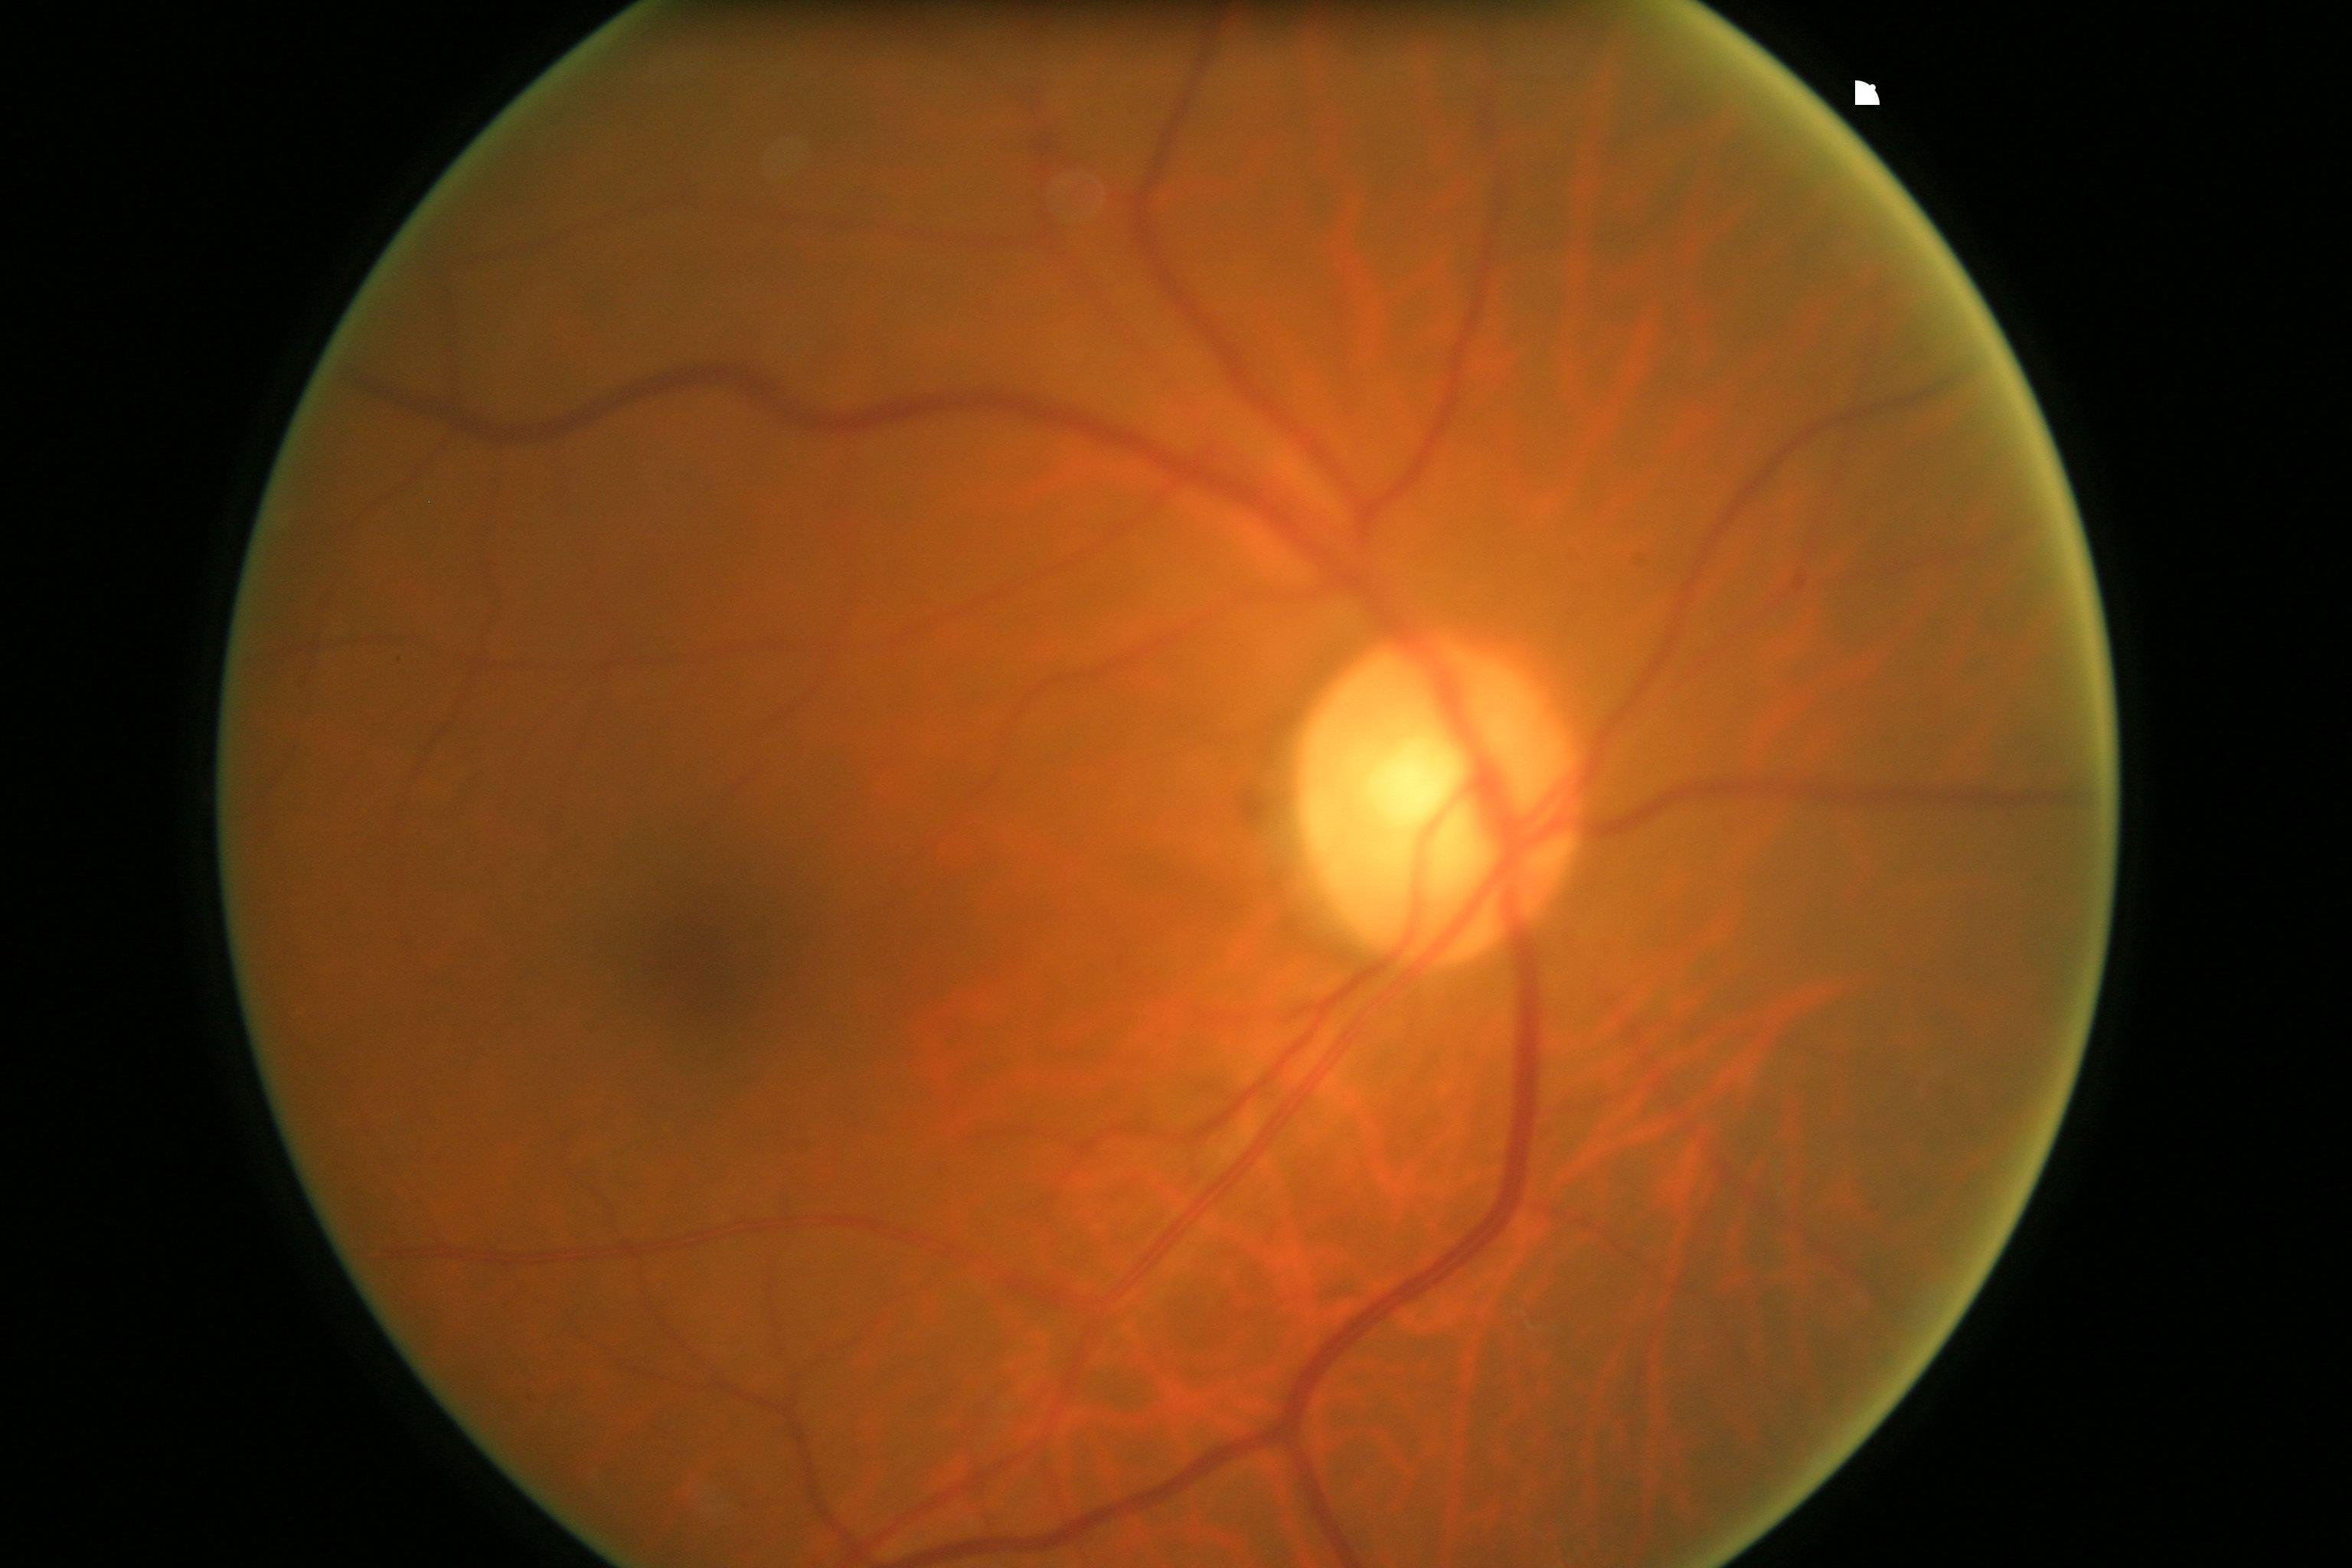

In [10]:
from IPython import display
display.Image(filename='./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', width=220, height=150)

In [11]:
#calculte the pixel mean and  min max value for a single image 
mean = pixels.mean()
print('Mean: %.3f'% mean)
#print the min and max value
print('Min: %.3f, Max: %.3f'% (pixels.min(), pixels.max()))

Mean: 63.332
Min: 0.000, Max: 255.000


#Resize and Rescale the Image to get a pixel range of 0-1

In [12]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([   
    layers.Resizing(150,220) , 
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape)

(150, 220, 3)


In [13]:
print('Min and Max Pixel Range:', result.numpy().min(), result.numpy().max())

Min and Max Pixel Range: 0.0 1.0


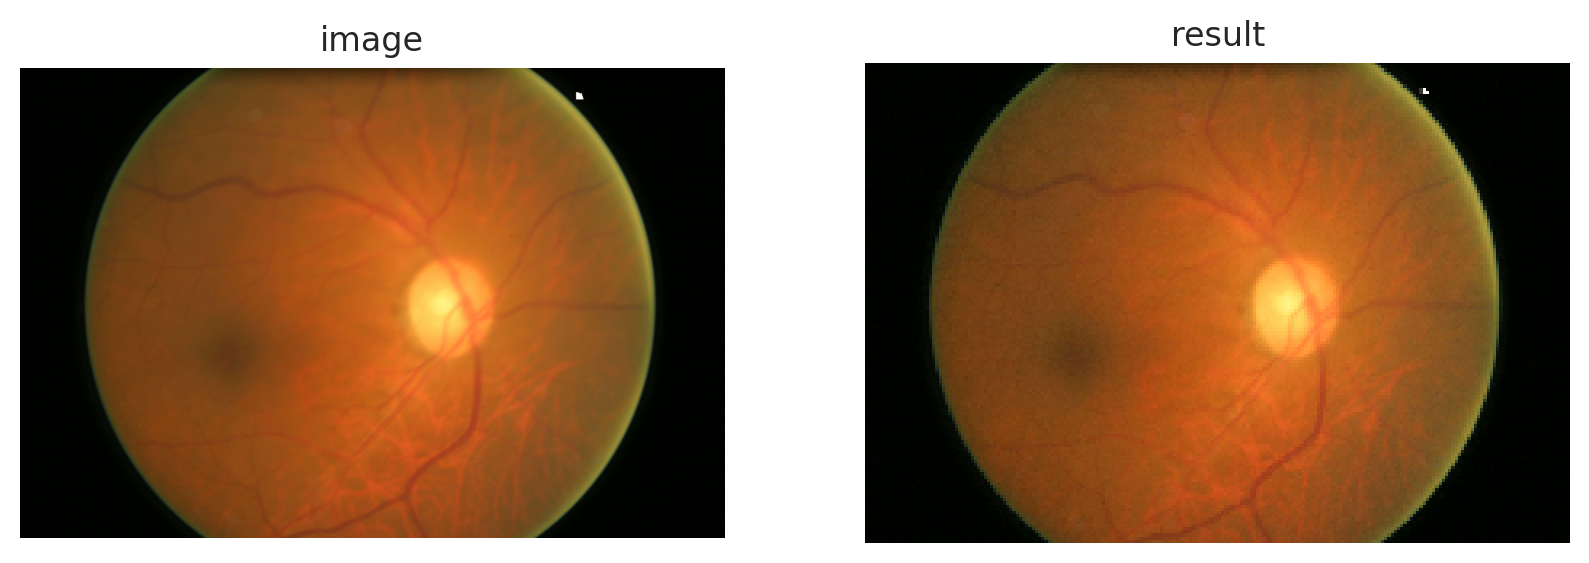

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show()

#Creating Train and Validation Datasets

Validation set - used to optimize the model parameters

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (160, 160) # very important to get this right, will determine model success
batch_size = 32

#training dataset
train_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Train/',
    image_size=image_size,
    shuffle=True,
    seed=1, #initialize a random number generator
    batch_size=batch_size
)

#validation testing dataset
val_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Validation/',
    image_size=image_size,
    shuffle=True,
    seed=1,
    batch_size=batch_size
)
print('520 files are training data divided into 2 classes: glaucoma positive and negative and \nsimilarly 130 files are the validation data divided into same classes.')

Found 520 files belonging to 2 classes.
Found 130 files belonging to 2 classes.
520 files are training data divided into 2 classes: glaucoma positive and negative and 
similarly 130 files are the validation data divided into same classes.


In [16]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [17]:
#Created test dataset by moving 20percent of validation set to it
#First find how many batches are there of val data
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [18]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 4
Number of test batches: 1


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#Data Augmentation 

In [20]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal_and_vertical", seed=42), 
      layers.RandomRotation(0.2, seed=42),
      layers.RandomContrast(0.1, seed=42)
    ])

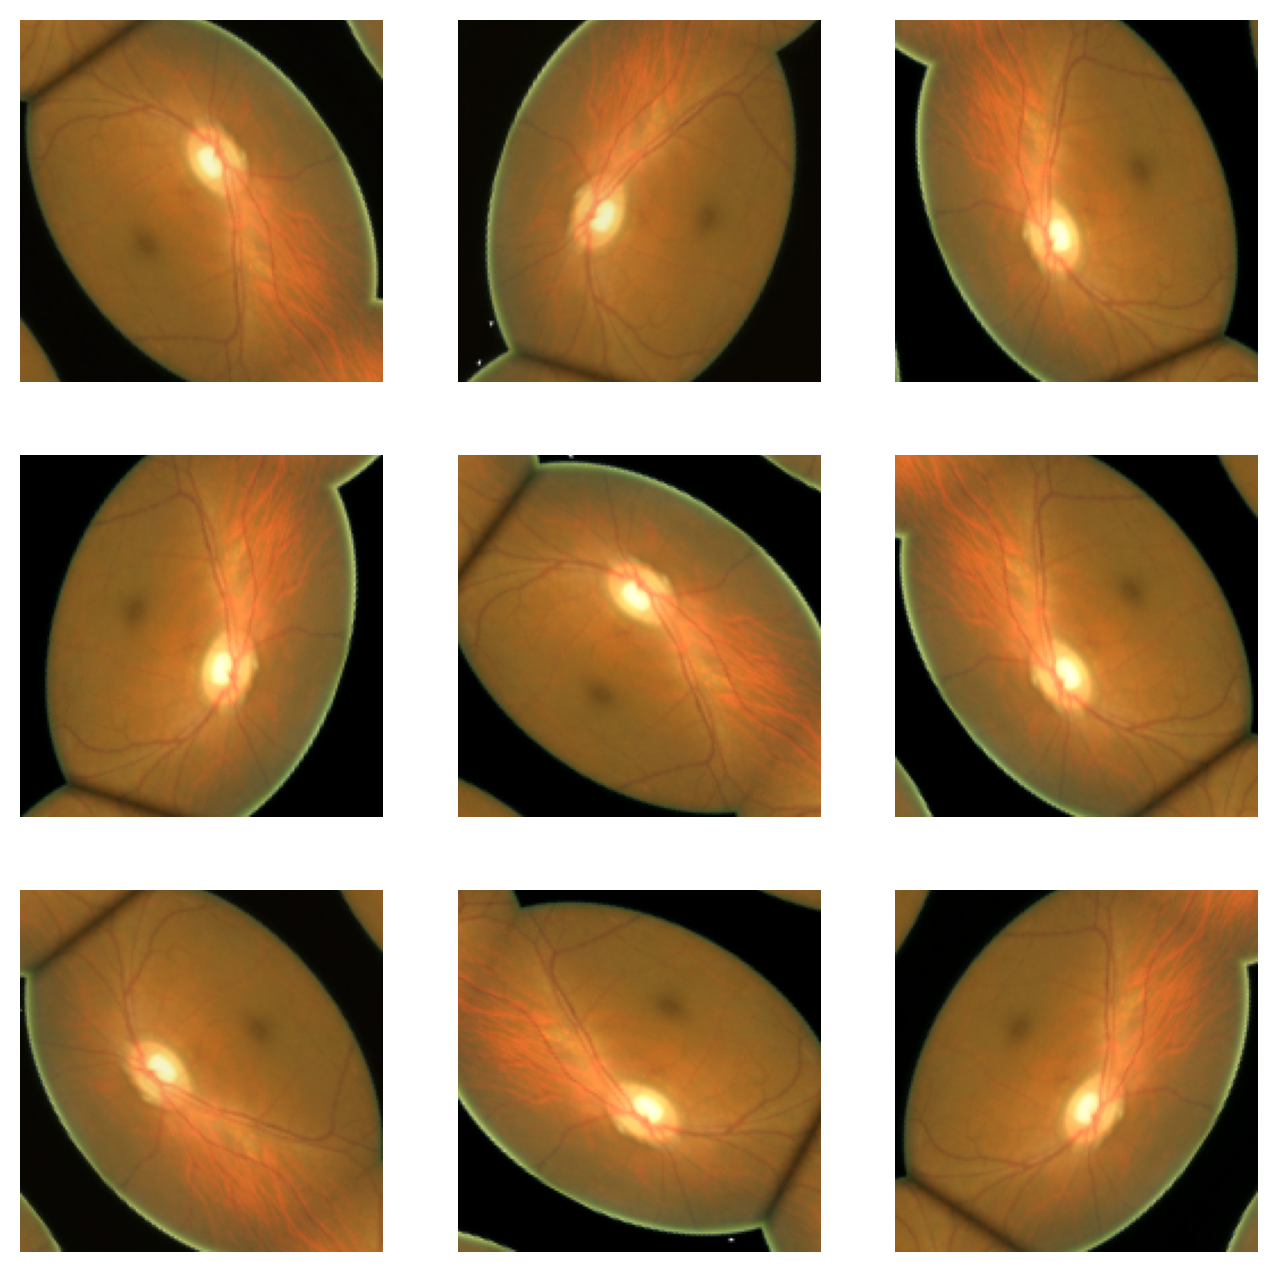

In [21]:
def augmented_img():
  for image, _ in train_ds.take(1): 
    plt.figure(figsize=(8, 8))
    first_image = image[0]
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255) # rescale pixel 0 to 1
      plt.axis("off")

augmented_img()

In [22]:
#rescale your image's pixel values for using the ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [23]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [25]:
base_model.trainable = False

In [26]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [27]:
#adding a classification layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [28]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [29]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
#Build and Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), # using Adam
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [32]:
len(model.trainable_variables)

2

In [33]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

4/4 [==============================] - 15s 3s/step - loss: 0.6542 - accuracy: 0.6837


In [34]:
print(loss0)
print(accuracy0)

0.6541697978973389
0.6836734414100647


In [35]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
17/17 [==============================] - 94s 5s/step - loss: 0.6408 - accuracy: 0.7231 - val_loss: 0.6092 - val_accuracy: 0.7245
Epoch 2/10
17/17 [==============================] - 76s 4s/step - loss: 0.6193 - accuracy: 0.7404 - val_loss: 0.6657 - val_accuracy: 0.7143
Epoch 3/10
17/17 [==============================] - 82s 5s/step - loss: 0.5757 - accuracy: 0.7442 - val_loss: 0.6384 - val_accuracy: 0.7245
Epoch 4/10
17/17 [==============================] - 80s 4s/step - loss: 0.6022 - accuracy: 0.7423 - val_loss: 0.6688 - val_accuracy: 0.6939
Epoch 5/10
17/17 [==============================] - 84s 5s/step - loss: 0.5894 - accuracy: 0.7442 - val_loss: 0.5934 - val_accuracy: 0.7245
Epoch 6/10
17/17 [==============================] - 81s 4s/step - loss: 0.5955 - accuracy: 0.7462 - val_loss: 0.5955 - val_accuracy: 0.7449
Epoch 7/10
17/17 [==============================] - 82s 5s/step - loss: 0.5835 - accuracy: 0.7308 - val_loss: 0.5989 - val_accuracy: 0.7347
Epoch 8/10
17/17 [==

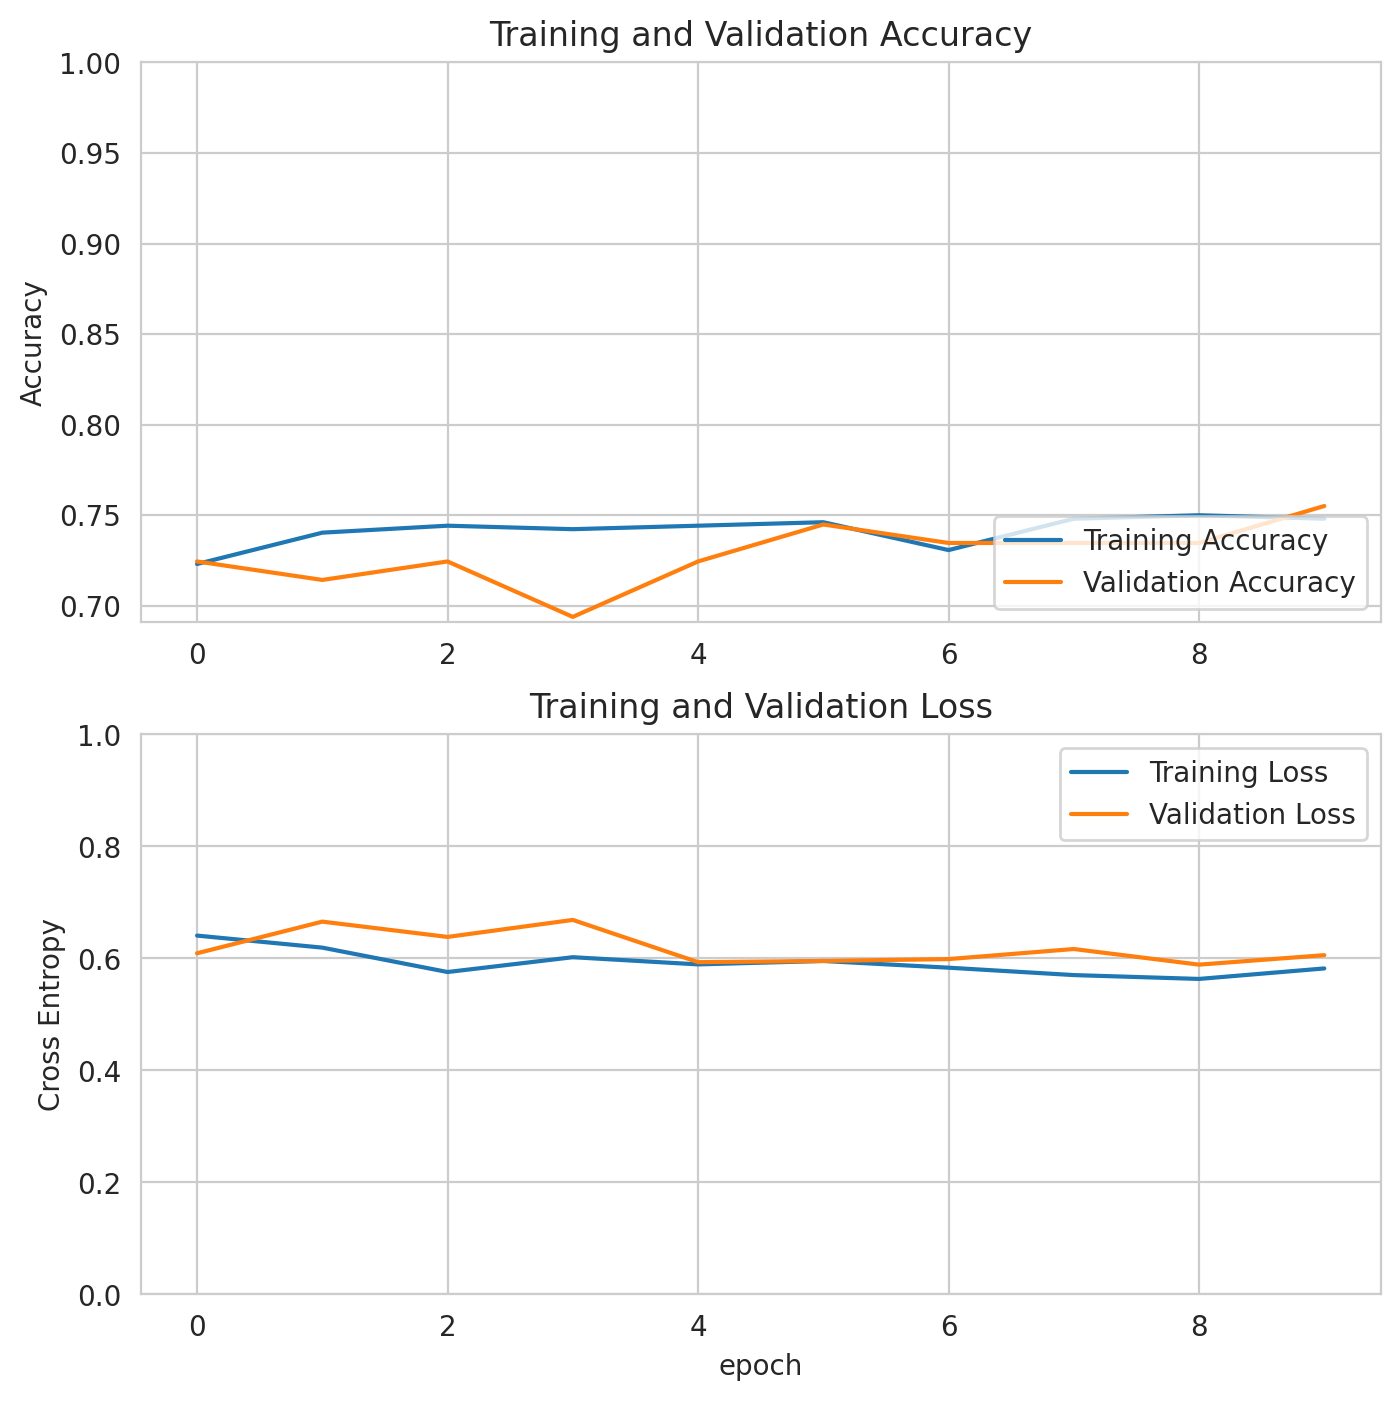

In [36]:
#Learning Curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine-Tuning the Model

In [43]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy','AUC'])

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [41]:
len(model.trainable_variables)

92

In [44]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
17/17 [==============================] - 150s 9s/step - loss: 0.4842 - accuracy: 0.7750 - auc: 0.6218 - val_loss: 0.5750 - val_accuracy: 0.7245 - val_auc: 0.5130
Epoch 11/20
17/17 [==============================] - 149s 9s/step - loss: 0.4685 - accuracy: 0.7731 - auc: 0.6675 - val_loss: 0.5669 - val_accuracy: 0.7041 - val_auc: 0.4784
Epoch 12/20
17/17 [==============================] - 149s 8s/step - loss: 0.4640 - accuracy: 0.7788 - auc: 0.6385 - val_loss: 0.5952 - val_accuracy: 0.7653 - val_auc: 0.4893
Epoch 13/20
17/17 [==============================] - 147s 8s/step - loss: 0.4831 - accuracy: 0.7788 - auc: 0.6327 - val_loss: 0.6189 - val_accuracy: 0.6939 - val_auc: 0.5108
Epoch 14/20
17/17 [==============================] - 149s 8s/step - loss: 0.4406 - accuracy: 0.7865 - auc: 0.6822 - val_loss: 0.6794 - val_accuracy: 0.7143 - val_auc: 0.4600
Epoch 15/20
17/17 [==============================] - 148s 8s/step - loss: 0.4676 - accuracy: 0.7692 - auc: 0.6529 - val_loss: 0.62

In [46]:
# base line accuracy to beat
(386 / (386 + 134) )* 100 

74.23076923076923

In [47]:
#Learning Curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

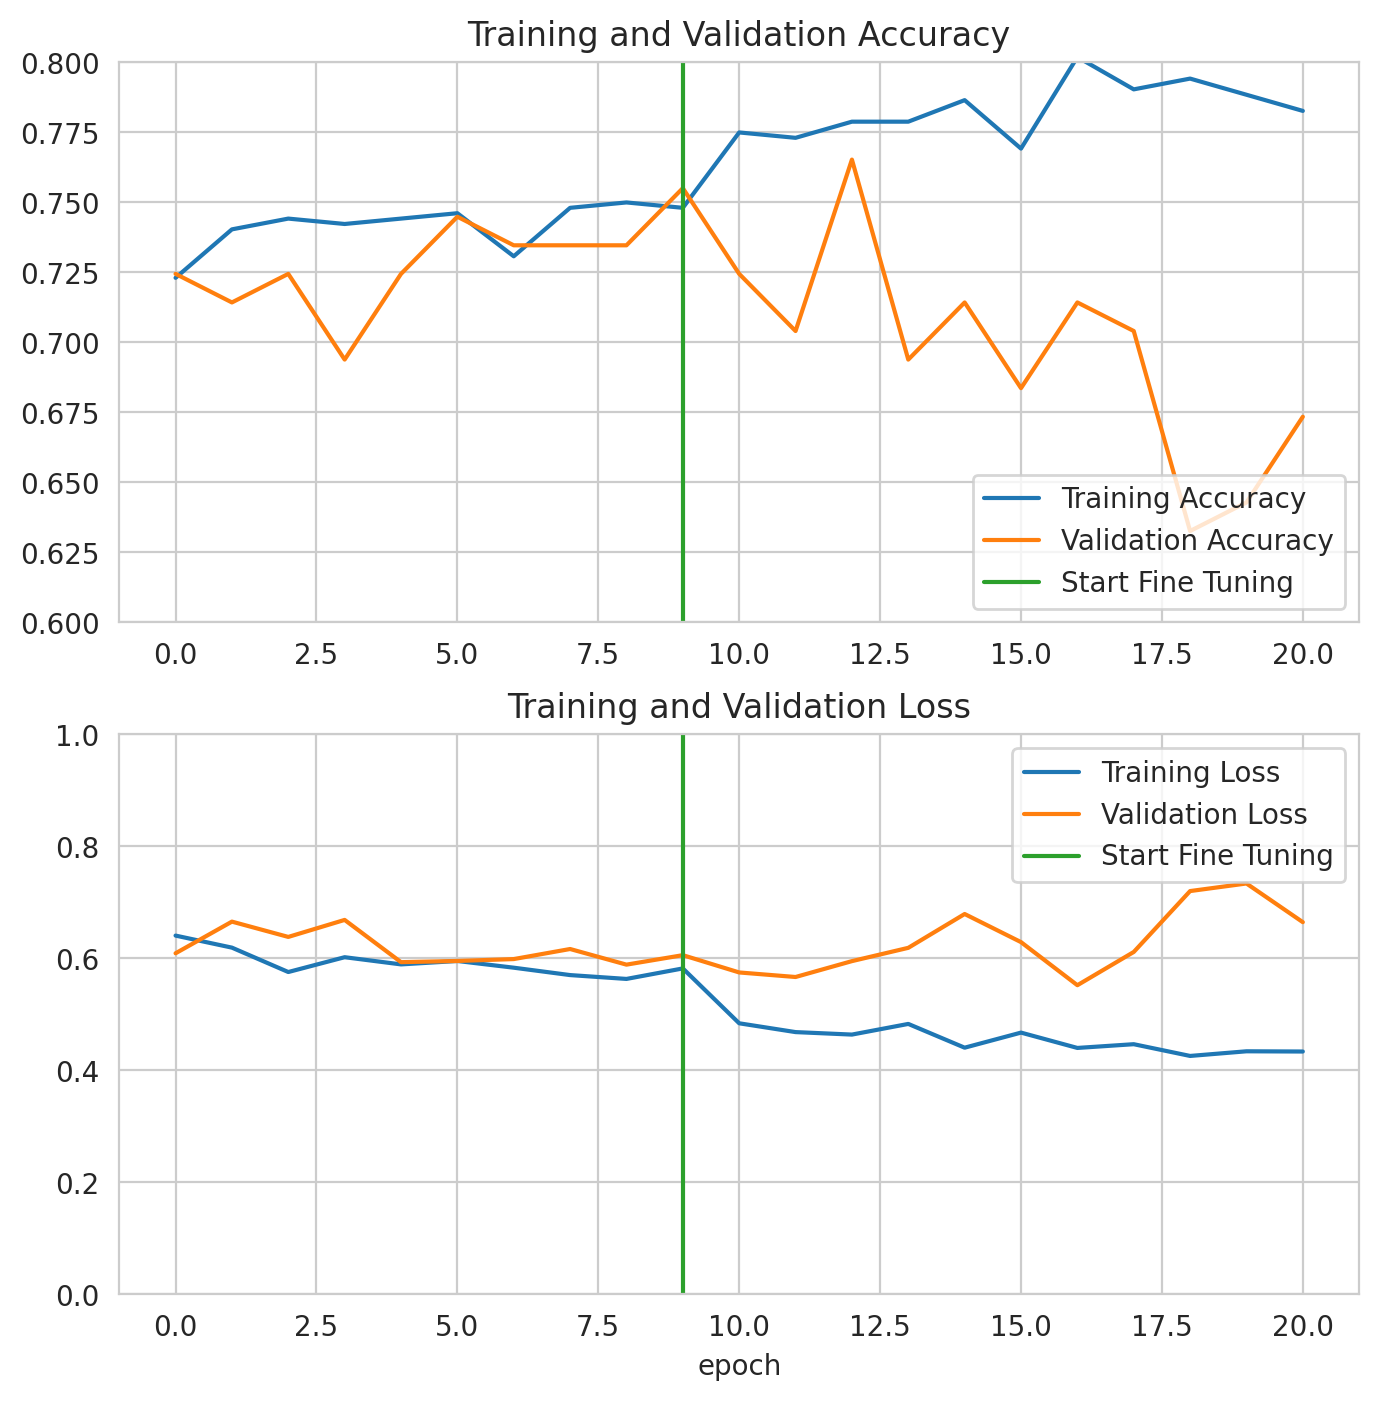

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 0.8])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Get Contours of Image
This might help with the performance as after finetuning the model was overfitted

In [51]:
import cv2
from google.colab.patches import cv2_imshow
def retina_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=30
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)

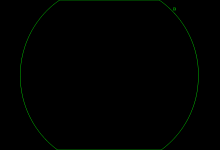

In [52]:
retina_contour()

In [53]:
def disc_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=155
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

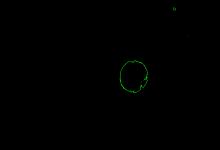

In [54]:
disc_contour()

Using WaterShed Algo to segment retina from black background

In [55]:
def mask():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cv2_imshow(cv2.resize(thresh, (220, 150), interpolation=cv2.INTER_AREA))
  return thresh

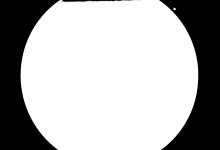

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [56]:
mask()

In [57]:
def remove_bg():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, alpha = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  
  b, g, r = cv2.split(img) # Using cv2.split() to split channels
  
  rgba = [b, g, r, alpha] # Making list of Red, Green, Blue channels and alpha

  new_img = cv2.merge(rgba, 4)

  cv2_imshow(cv2.resize(new_img, (220, 150), interpolation=cv2.INTER_AREA))
  # if needed, save image
  cv2.imwrite("./GA_Capstone/EDA/no_bg.png", new_img) # jpg does not support alpha channel, only png or tiff format
  return new_img

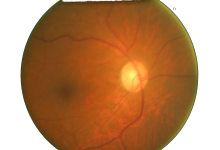

array([[0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       ...,
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0]], dtype=uint8)

In [58]:
remove_bg()[0]

In [59]:
image2 = cv2.imread('./GA_Capstone/EDA/no_bg.png', cv2.IMREAD_UNCHANGED)
print(image2.shape) # 4 channels
pixels2 = np.asarray(image2) # show numpy array format

print(pixels2[0])

(2048, 3072, 4)
[[0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]
 ...
 [0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]]


In [60]:
def augmented_imgs():
  plt.figure(figsize=(8, 8))
  img = tf.io.read_file("./GA_Capstone/EDA/no_bg.png")
  # convert to tensor
  tensor = tf.io.decode_image(img, channels=4, dtype=tf.dtypes.float32)
  # resize tensor to 255 x 255
  tensor = tf.image.resize(tensor, [255, 255]) # tensor.shape # (255, 255, 4)
  # add another dimension at the front to get NHWC shape
  input_tensor = tf.expand_dims(tensor, axis=0) #input_tensor.shape (1, 255, 255, 4)
  for i in range(9):
    augmented_image = data_augmentation(input_tensor)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("float32")) # to be same as tf.dataset object type
    # float32 tensors
    plt.axis("off")

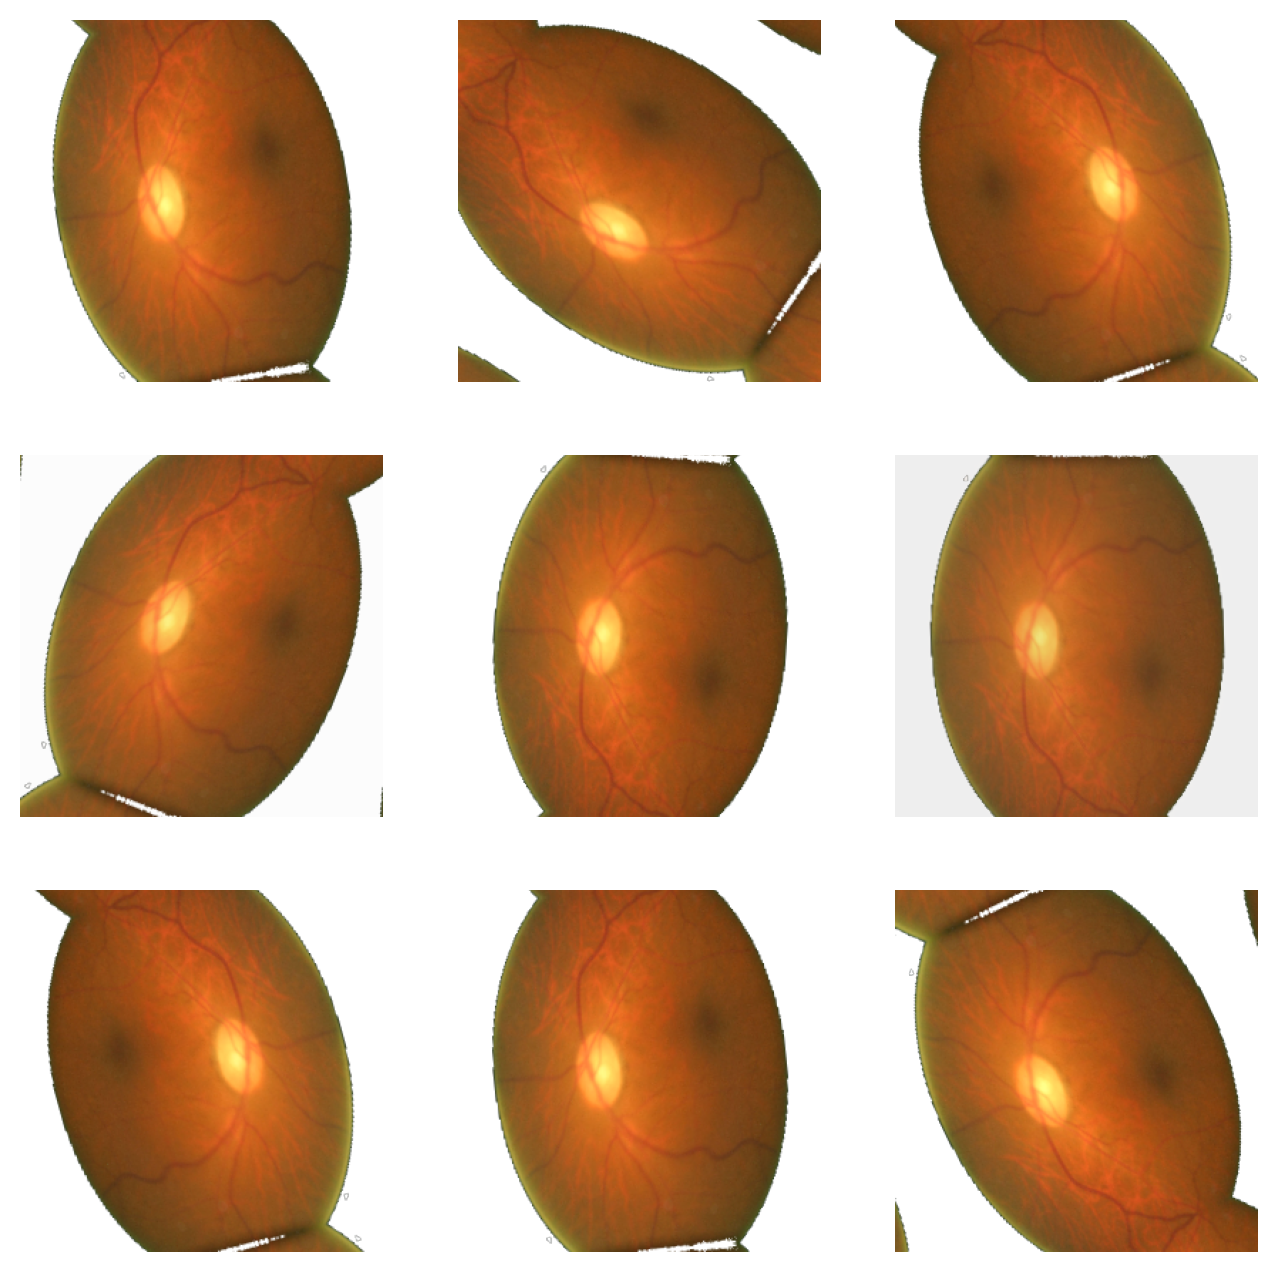

In [61]:
augmented_imgs()